## Day 34 Lecture 2 Assignment

In this assignment, we will learn about gradient boosting. We will use a dataset of house information in Ames, Iowa, predicting sale price.

In [34]:
%matplotlib inline

import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder



from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, mean_absolute_error

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

In [4]:
house = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/houseprices.csv')
print(house.shape)
house.head()

(1460, 81)


,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,...,centralair,electrical,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1460 non-null   int64  
 1   mssubclass     1460 non-null   int64  
 2   mszoning       1460 non-null   object 
 3   lotfrontage    1201 non-null   float64
 4   lotarea        1460 non-null   int64  
 5   street         1460 non-null   object 
 6   alley          91 non-null     object 
 7   lotshape       1460 non-null   object 
 8   landcontour    1460 non-null   object 
 9   utilities      1460 non-null   object 
 10  lotconfig      1460 non-null   object 
 11  landslope      1460 non-null   object 
 12  neighborhood   1460 non-null   object 
 13  condition1     1460 non-null   object 
 14  condition2     1460 non-null   object 
 15  bldgtype       1460 non-null   object 
 16  housestyle     1460 non-null   object 
 17  overallqual    1460 non-null   int64  
 18  overallc

Check for nulls. Remove any columns with more than 100 nulls, then drop any remaining rows with nulls after that.

In [6]:
# your work here
missing_values = house.isnull().sum()
missing_values[missing_values > 100].sort_values(ascending=False)

poolqc         1453
miscfeature    1406
alley          1369
fence          1179
fireplacequ     690
lotfrontage     259
dtype: int64

In [7]:
house.drop(missing_values[missing_values>100].index, 1, inplace=True)
house.dropna(inplace=True)

One hot encode your categorical features using get_dummies.

In [8]:
# your work here
# for col in house.select_dtypes(include='O').columns:
#   print(f'{col} has {house[col].nunique()} nunique. Value counts:\n {house[col].value_counts()}')

In [15]:
cat_features = house.select_dtypes(include='O')
num_features = house.select_dtypes(exclude='O')

onehot = OneHotEncoder(drop='first', sparse=False)

cat_features_proc = pd.DataFrame(onehot.fit_transform(cat_features), 
                                 columns=onehot.get_feature_names(),
                                 index=cat_features.index)

In [17]:
house_proc = pd.concat([num_features, cat_features_proc], 1)

Take a look at your outcome variable. It is highly skewed, and has a few very rare large outliers.

Let's try log transforming the y variable.

In [20]:
# your work here
y_log = np.log(house['saleprice'])

We know that there are some rare large values. We can make sure that the training and test sets have about the same distribution by stratifying the train-test split.

Split your training and test sets, with a test size of 0.2. Use the given helper function to stratify the continuous outcome. Remember that the outcome variable is now the **log of sale price**.

In [25]:
np.linspace(0, 10, 100+1)[:-1]

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
       3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1,
       5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4,
       6.5, 6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7,
       7.8, 7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. ,
       9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9])

In [21]:
def binned(y, num_bins):
    # Creates an object to put in the stratify keyword in train_test_split
    # Specify number of bins to separate your y variable
    ymin, ymax = y.min(), y.max()
    bins = np.linspace(ymin, ymax, num_bins+1)[:-1]
    y_binned = np.digitize(y, bins)
    return y_binned

In [32]:
# your work here
X = house_proc.drop('saleprice', 1)
y_bin = binned(y_log, 20)
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, stratify=y_bin)

Create a Gradient Boosting Regressor model. Measure the MAE (Mean Absolute Error) for the training and testing sets.

In [38]:
def get_scores(model, X_train, X_test, y_train, y_test, verbose=False):
  if verbose:
    print(f'Training Scores: {model.score(X_train, y_train)}')
    print(f'Test Scores: {model.score(X_test, y_test)}')
  return model.score(X_train, y_train), model.score(X_test, y_test)

In [36]:
# your work here
gbr = GradientBoostingRegressor(learning_rate=0.1, max_depth=4, n_iter_no_change=10, n_estimators=10000)
gbr.fit(X_train, y_train_log)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=10000,
                          n_iter_no_change=10, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [40]:
get_scores(gbr, X_train, X_test, y_train_log, y_test_log, verbose=True)

Training Scores: 0.9720788292371874
Test Scores: 0.9004024151984447


(0.9720788292371874, 0.9004024151984447)

In [41]:
print(f'MAE: {mean_absolute_error(y_test_log, gbr.predict(X_test))}')

MAE: 0.08217335734418177


Create a grid search. Try varying subsample, learning rate, and max features. Use MAE as your scoring metric.

In [66]:
# your work here
gbr = GradientBoostingRegressor(max_depth=4, n_iter_no_change=10, n_estimators=10000)
params = {'learning_rate': [.05, .1, .025], 
          'subsample': [1.0, 0.95, 0.9, 0.85], 
          'max_features': [None, 'sqrt', 'log2', 0.75]}

gbr_grid = GridSearchCV(gbr, param_grid=params, scoring='neg_mean_absolute_error', cv=3)

gbr_grid.fit(X_train, y_train_log)

GridSearchCV(cv=3, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=4,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=10000,
                                                 n_iter...
                            

In [68]:
gbr_grid.best_estimator_

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.025, loss='ls',
                          max_depth=4, max_features='sqrt', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=10000,
                          n_iter_no_change=10, presort='deprecated',
                          random_state=None, subsample=0.85, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [69]:
for key in params.keys():
  print(f'{key} = {getattr(gbr_grid.best_estimator_, key)}')

learning_rate = 0.025
subsample = 0.85
max_features = sqrt


In [93]:
gbr_grid.best_params_

{'learning_rate': 0.025, 'max_features': 'sqrt', 'subsample': 0.85}

In [70]:
get_scores(gbr_grid, X_train, X_test, y_train_log, y_test_log, verbose=True)

Training Scores: -0.05747240918623614
Test Scores: -0.07436377165239183


(-0.05747240918623614, -0.07436377165239183)

In [71]:
print(f'MAE: {mean_absolute_error(y_test_log, gbr_grid.predict(X_test))}')

MAE: 0.07436377165239183


Create residual plots of the training and test sets and interpret your results.

In [72]:
# your work here
y_pred_train = gbr_grid.predict(X_train)
residuals_training = np.array(y_pred_train) - np.array(y_train_log)
np.mean(residuals_training)

0.0002782314360403617

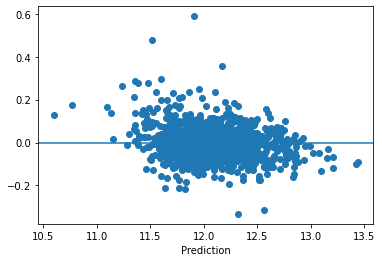

In [73]:
plt.scatter(y_pred_train, residuals_training)
plt.axhline(y=0)
plt.xlabel('Prediction')
plt.show()

In [74]:
y_pred_test = gbr_grid.predict(X_test)
residuals_test = np.array(y_pred_test) - np.array(y_test_log)
np.mean(residuals_test)

0.004862521437958872

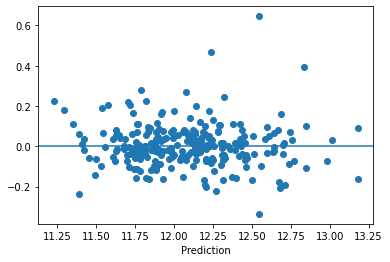

In [75]:
plt.scatter(y_pred_test, residuals_test)
plt.axhline(y=0)
plt.xlabel('Prediction')
plt.show()

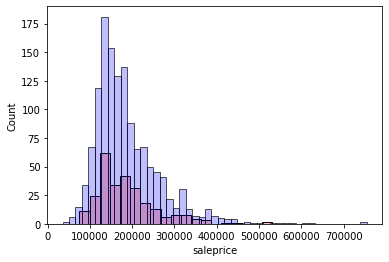

In [92]:
sns.histplot(np.exp(y_pred_test), color='r', alpha=0.25)
sns.histplot(house['saleprice'], color='b', alpha=0.25)
plt.show()